### Customer Segmentation
In this notebook we are going to use clustering in segmenting customers using unsupervised machine learning algorithims using the dataset that was obtained from kaggle [`Shop Customer Data`](https://www.kaggle.com/datasets/datascientistanna/customers-dataset)

> Dataset: https://www.kaggle.com/datasets/datascientistanna/customers-dataset

First we are going to start by installing the package `pigmenta` for color palettes, that we are going to use for visualization.

In [1]:
pip install pigmenta -q

Note: you may need to restart the kernel to use updated packages.


Next we are going to import all the packages that we are going to use in this notebook.

In [4]:
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pigmenta import PALETTES
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.1.4
numpy: 1.26.4


### Seed
In the following code cell we are going to set the `seed` for all random operations for reproducivity in this notebook.

In [6]:
SEED = 17
np.random.seed(SEED)
random.seed(SEED)

In the following code cell we are going to read the data using pandas to a dataframe.

In [8]:
dataframe = pd.read_csv("Customers (1).csv")
dataframe.head(2)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3


Next we are going to remove the `CustomerID` column since it doesn't mater in this case.

In [10]:
dataframe.drop(columns=["CustomerID"], inplace=True)
dataframe.head(2)

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3


Next we are going to rename our columns in the dataset.

In [15]:
dataframe.rename(columns={"Gender": "gender", "Age": "age", "Annual Income ($)": "income", 
                          "Spending Score (1-100)": "spending",  "Profession": "profession",
                          "Work Experience": "experience", "Family Size": "fam_size" }, inplace=True)
dataframe.head(2)

,gender,age,income,spending,profession,experience,fam_size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3


In [19]:
print(f"Examples: {len(dataframe):,}")

Examples: 2,000


Next we are going to remove all `na` rows of the data from the dataset.

In [23]:
if sum(dataframe.isna().any()):
    dataframe.dropna(inplace=True)
    dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()

gender        False
age           False
income        False
spending      False
profession    False
experience    False
fam_size      False
dtype: bool

In [35]:
print(f"Examples: {len(dataframe):,}")

Examples: 1,965


In the following code cell we are going to categorize some numerical columns into differente caterories.

In [38]:
def spending_category(spending:int)->str:
    if spending >= 60:
        return "high"
    elif spending >= 30:
        return "medium"
    else:
        return "low"

def income_category(income:int)->str:
    if income >= 180_000:
        return "high"
    elif income >= 100_000:
        return "medium"
    else:
        return "low"
        
def categorize_family(size):
    if 1 <= size <= 3:
        return "small"
    elif 4 <= size <= 6:
        return "medium"
    else:
        return "large"

def age_category(age: int) -> str:
    if age <= 12:
        return "child"
    elif age <= 19:
        return "Teen"
    elif age <= 35:
        return "young adult"
    elif age <= 55:
        return "adult"
    elif age <= 74:
        return "senior"
    else:
        return "elderly"

def experience_category(years: int) -> str:
    if years <= 1:
        return "beginner"
    elif years <= 5:
        return "junior"
    elif years <= 10:
        return "intermediate"
    else:
        return "senior"

dataframe.gender     = dataframe.gender.apply(lambda x: x.lower())
dataframe.profession = dataframe.profession.apply(lambda x: x.lower())
dataframe.age        = dataframe.age.apply(age_category)
dataframe.experience = dataframe.experience.apply(experience_category)
dataframe.fam_size   = dataframe.fam_size.apply(categorize_family)
dataframe.spending   = dataframe.spending.apply(spending_category)
dataframe.income      = dataframe.income.apply(income_category)
dataframe.head()

,gender,age,income,spending,profession,experience,fam_size
0,male,Teen,low,medium,healthcare,beginner,medium
1,male,young adult,low,high,engineer,junior,small
2,female,young adult,low,low,engineer,beginner,small
3,female,young adult,low,high,lawyer,beginner,small
4,female,young adult,low,medium,entertainment,junior,medium


In the following code cell we are then going to do some categorical/relational  plots based on `Gender` and other categorical columns.

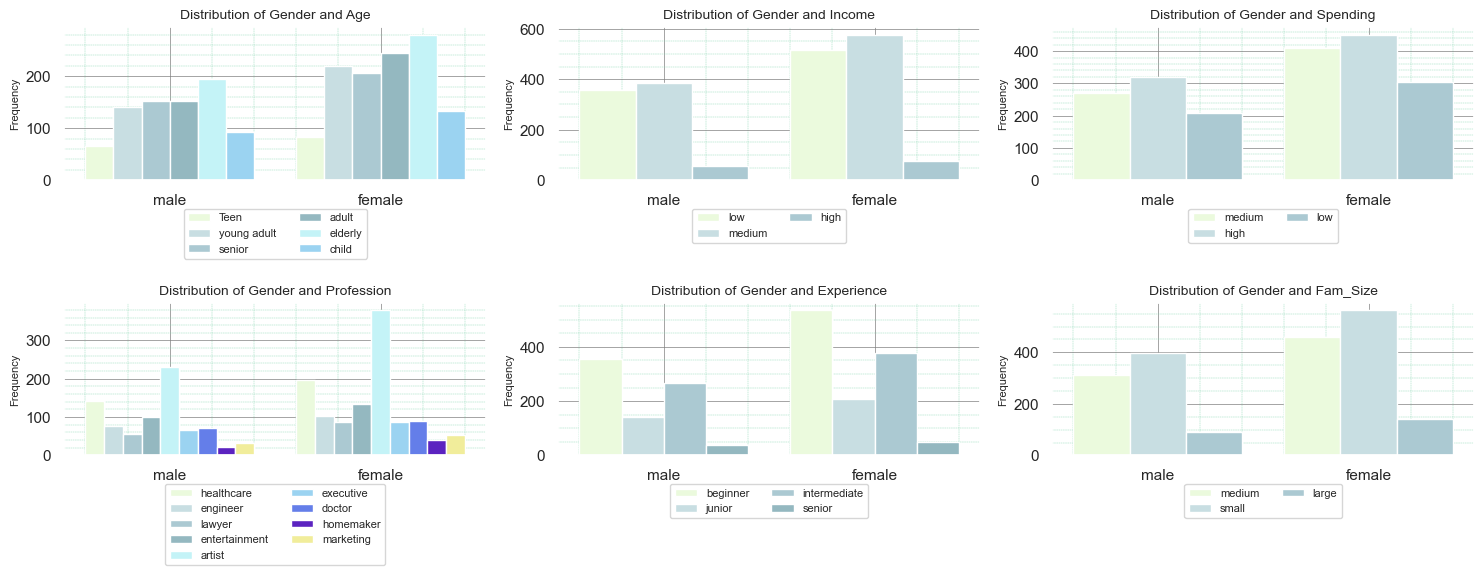

In [41]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharey=False)
axes = axes.flatten()

for index, col in enumerate(dataframe.columns[1:]):
    sns.countplot(data=dataframe, x="gender", hue=col, palette=PALETTES.sky,  ax=axes[index], fill=True)
    axes[index].set_xlabel("", fontsize=8)
    axes[index].set_ylabel("Frequency", fontsize=8)
    axes[index].set_title(f"Distribution of Gender and {col.title()}", fontsize=10)
    axes[index].minorticks_on()
    axes[index].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    axes[index].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
    axes[index].legend(fontsize=8,  loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()


We are not going to split the data into different sets, however we are going transform all the features into numerical, by first using the ordinal encoder to convert the features to numbers and then use the standard scale to scale the features to be standard normal.

In [43]:
numericalize = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('min_max_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("pre-processing", numericalize, dataframe.columns),
], remainder='passthrough')

X = ct.fit_transform(dataframe)

Next we are going to find the best algorithm that can best fit the data between the following:

1. `KMeans`
2. `AgglomerativeClustering`
3. `GaussianMixture`
4. `SpectralClustering`

By calculating the `silhouette_score`. The higher the score the better the algorithm.

In [47]:
N_CLUSTERS = 3

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init='auto')
hierarchical = AgglomerativeClustering(n_clusters=N_CLUSTERS)
gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='full', random_state=SEED)
spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors', 
                              assign_labels='kmeans', random_state=SEED)
pipelines = [kmeans,  hierarchical, gmm, spectral]
pipe_dict = {0: 'kmeans',  1: 'hierarchical', 2: "gmm", 3: 'spectral'}

def get_scores(X):
    scores = []
    for i, pipe in enumerate(pipelines):
        labels = pipe.fit_predict(X)
        score = {
            'score': silhouette_score(X, labels), 'algorithim': pipe_dict[i]
        }
        scores.append(score)
    return scores

scores = get_scores(X)
scores

[{'score': 0.12813814974997573, 'algorithim': 'kmeans'},
 {'score': 0.10420107200261686, 'algorithim': 'hierarchical'},
 {'score': 0.12828334527010984, 'algorithim': 'gmm'},
 {'score': 0.12971313272917998, 'algorithim': 'spectral'}]

We are setting number of clusters to `3` meaning that we are segmenting our customers into 3 segments.

In [50]:
scores_df  = pd.DataFrame(scores)
scores_df

,score,algorithim
0,0.128138,kmeans
1,0.104201,hierarchical
2,0.128283,gmm
3,0.129713,spectral


Next we are going to plot the scores for the algorithmns.

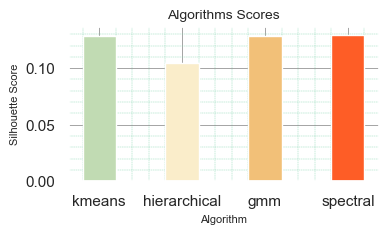

In [53]:
plt.figure(figsize=(4, 2))
plt.bar(scores_df.algorithim.values, scores_df.score.values, color=PALETTES.rainbow, width=.4)
plt.title('Algorithms Scores', fontsize=10)
plt.xlabel('Algorithm', fontsize=8)
plt.ylabel('Silhouette Score', fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()

The `SpectralClustering` was the better algorithm for the data, next we are going to make predictions and reduce the dimentions of the features to 2 so that we can plot the clusters after.

In [59]:
spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors', 
                              assign_labels='kmeans', random_state=SEED)
spectral_labels = spectral.fit_predict(X)
X_reduced = TSNE(n_components=2, perplexity=30).fit_transform(X)

Finally we are going to plot the segments of customers.

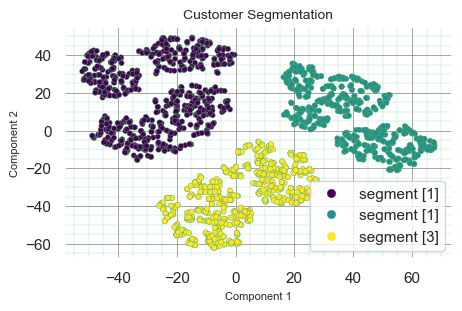

In [86]:
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=spectral_labels, cmap='viridis', s=15,  edgecolor="g", linewidths=0.3 
)
plt.title("Customer Segmentation", fontsize=10)
plt.xlabel("Component 1", fontsize=8)
plt.ylabel("Component 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=[f"segment [{i+1}]" for i in spectral_labels])
plt.minorticks_on()
plt.show()